2023-12-14 13:14:24.476796: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-14 13:14:24.476828: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-14 13:14:24.476833: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-14 13:14:24.476866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 13:14:24.476879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-12-14 13:14:28.459303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 61s 821ms/step - loss: 1.4909 - accuracy: 0.5792 - precision: 0.6220 - recall: 0.4659 - F1Score: 0.5107 - val_loss: 0.9697 - val_accuracy: 0.5333 - val_precision: 0.5333 - val_recall: 0.5333 - val_F1Score: 0.5245
Epoch 2/10
65/65 [==============================] - 52s 798ms/step - loss: 1.3610 - accuracy: 0.6229 - precision: 0.6598 - recall: 0.5766 - F1Score: 0.6143 - val_loss: 0.8767 - val_accuracy: 0.5333 - val_precision: 0.5598 - val_recall: 0.5282 - val_F1Score: 0.5419
Epoch 3/10
65/65 [==============================] - 52s 798ms/step - loss: 1.2054 - accuracy: 0.6885 - precision: 0.7025 - recall: 0.6564 - F1Score: 0.6766 - val_loss: 0.7293 - val_accuracy: 0.7641 - val_precision: 0.7668 - val_recall: 0.7590 - val_F1Score: 0.7581
Epoch 4/10
65/65 [==============================] - 52s 800ms/step - loss: 0.6876 - accuracy: 0.8533 - precision: 0.8628 - recall: 0.8340 - F1Score: 0.8460 - val_loss: 1.0396 - val_accuracy: 0.4615 - val_precision: 0

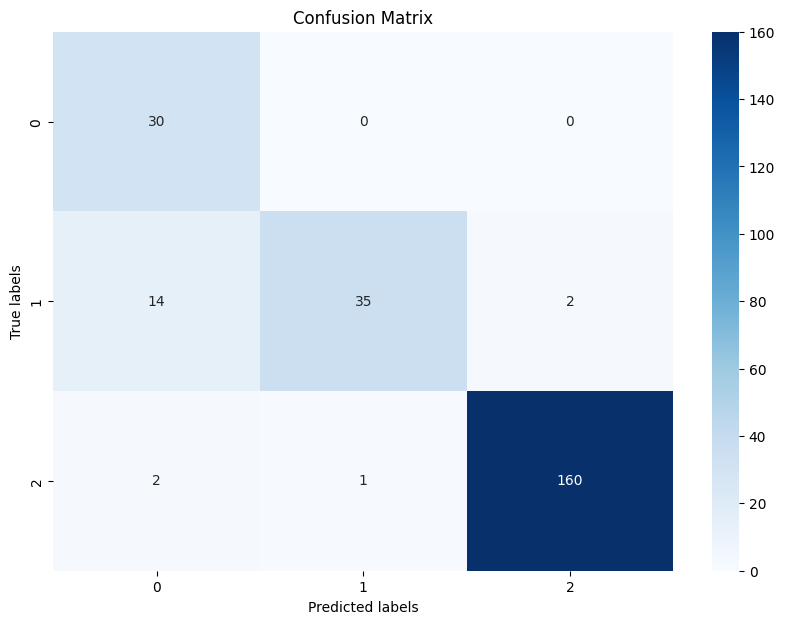

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

# Mount Google Drive (specific to Google Colab)
# from google.colab import drive
# drive.mount('/content/gdrive')
# data = pd.read_csv('/content/gdrive/MyDrive/RoadSense/01_tracks-2.csv')

tracks1 = pd.read_csv('01_tracks.csv')
tracks2 = pd.read_csv('02_tracks.csv')
tracks3 = pd.read_csv('03_tracks.csv')
tracks4 = pd.read_csv('04_tracks.csv')
tracks5 = pd.read_csv('05_tracks.csv')


def get_lane_changed_ID(data):
    unique_ID = len(data['id'].unique())
    r_to_l = list()
    l_to_r = list()
    for i in range(1, unique_ID):
        vehicle = data.loc[data["id"] == i]
        if vehicle['laneId'].iloc[0] < 3.5 and vehicle['laneId'].iloc[0] - vehicle['laneId'].iloc[-1] > 0:
            r_to_l.append(i)
        if vehicle['laneId'].iloc[0] < 3.5 and vehicle['laneId'].iloc[0] - vehicle['laneId'].iloc[-1] < 0:
            l_to_r.append(i)
        if vehicle['laneId'].iloc[0] > 3.5 and vehicle['laneId'].iloc[0] - vehicle['laneId'].iloc[-1] > 0:
            l_to_r.append(i)
        if vehicle['laneId'].iloc[0] > 3.5 and vehicle['laneId'].iloc[0] - vehicle['laneId'].iloc[-1] < 0:
            r_to_l.append(i)

    return r_to_l, l_to_r

r_to_l, l_to_r = get_lane_changed_ID(data)


data['lane_change'] = 0
data.loc[data['id'].isin(r_to_l), 'lane_change'] = 1
data.loc[data['id'].isin(l_to_r), 'lane_change'] = 2

columns_to_drop = [
    'frontSightDistance', 'backSightDistance', 'dhw', 'thw', 'ttc',
    'precedingXVelocity', 'precedingId', 'followingId', 'leftPrecedingId',
    'leftAlongsideId', 'leftFollowingId', 'rightPrecedingId', 'rightAlongsideId',
    'rightFollowingId', 'laneId', 'width', 'height', 'frame'
]
data = data.drop(columns_to_drop, axis=1)

grouped = data.groupby('id')
sequences = [group.drop('id', axis=1).values for _, group in grouped]

max_sequence_length = max(len(s) for s in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')

# Convert labels to one-hot encoded format
labels = np.array([group['lane_change'].iloc[0] for _, group in grouped])
one_hot_labels = to_categorical(labels, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(max_sequence_length, padded_sequences.shape[2]), dropout=0.2)),
    Bidirectional(tf.keras.layers.LSTM(30, dropout=0.2)),
    tf.keras.layers.Dense(3, activation='softmax')
])

def F1Score(y_true, y_pred):
    # Calculating Precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    # Calculating Recall
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    # Calculating F1 Score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score])

class_weights = {0: 1, 1: 2, 2: 2}

history = model.fit(X_train, y_train, epochs=10, batch_size=12, validation_split=0.2, class_weight=class_weights)

loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1 Score: {f1_score:.4f}")

f1_score = F1Score(y_test, model.predict(X_test))
print(f"Test F1 Score: {f1_score:.4f}")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
np.shape(l_to_r)

(731,)